In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
sns.set_theme()


In [3]:
native_df = pd.read_csv(Path(Path.home(), "Documents/xray/dev/29_synthetic_native_3/data/scores/7mhf_30.csv"))
native_df.head()

,Unnamed: 0,pdb,w_0_0,w_1_0,w_0_1,w_1_1,xray_0,r_free_0,rmsd_0,ff,xray_1,r_free_1,rmsd_1
0,0,/wynton/group/sali/mhancock/xray/sample_bench/...,0.510588,0.489412,0.555566,0.444434,4.025633,0.039276,0.0,21250.054492,4.053322,0.043427,0.0
1,1,/wynton/group/sali/mhancock/xray/sample_bench/...,0.893325,0.106675,0.739213,0.260787,4.227168,0.040899,0.0,20682.124765,4.121057,0.041334,0.0
2,2,/wynton/group/sali/mhancock/xray/sample_bench/...,0.585996,0.414004,0.582210,0.417790,4.054030,0.040999,0.0,20822.373139,4.048832,0.040720,0.0
3,3,/wynton/group/sali/mhancock/xray/sample_bench/...,0.375460,0.624540,0.297137,0.702863,4.064986,0.041624,0.0,21136.167610,4.103359,0.040295,0.0
4,4,/wynton/group/sali/mhancock/xray/sample_bench/...,0.303720,0.696280,0.357188,0.642812,4.093771,0.041402,0.0,20683.275695,4.082613,0.040715,0.0


In [4]:
score_df = pd.read_csv(Path(Path.home(), "Documents/xray/score_bench/data/7mhf/122_native_decoys_1_state/rand1000_1.csv"))
score_df.head()

,Unnamed: 0,ff,rmsd_0,w_0_0,pdb,xray_0,r_free_0
0,0,-76.820288,0.919565,1.0,/wynton/group/sali/mhancock/xray/sample_bench/...,6.534940,0.489923
1,1,619.645941,0.966754,1.0,/wynton/group/sali/mhancock/xray/sample_bench/...,6.540651,0.505870
2,2,26.067973,0.919300,1.0,/wynton/group/sali/mhancock/xray/sample_bench/...,6.535120,0.513216
3,3,-108.567924,0.955506,1.0,/wynton/group/sali/mhancock/xray/sample_bench/...,6.551427,0.517936
4,4,-98.278021,0.900608,1.0,/wynton/group/sali/mhancock/xray/sample_bench/...,6.533372,0.506770


In [5]:
def logistic_func(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

def fp(x,L,k,x0):
    return (L * k * np.exp(-k * (x - x0))) / (1 + np.exp(-k * (x - x0)))**2

def fdp(x,L,k,x0):
    return (L * k**2 * np.exp(-2*k * (x - x0)) * (-np.exp(k * (x - x0)) + 1)) / (1 + np.exp(-k * (x - x0)))**3

[ 6.54667239  7.46015726 -0.00958087]


[]

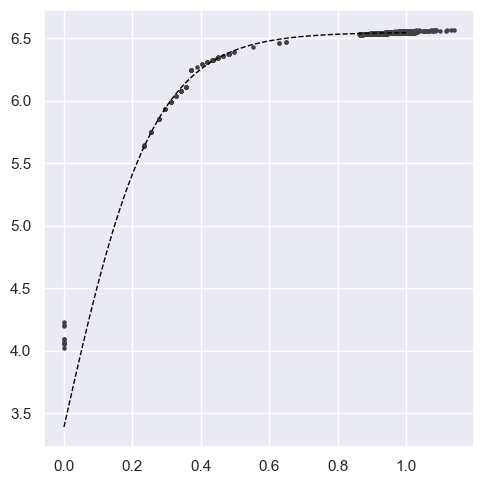

In [6]:
# xs = score_df[(score_df["rmsd_0"] < 1) & (score_df["rmsd_0"] > .01)]["rmsd_0"]
# ys = score_df[(score_df["rmsd_0"] < 1) & (score_df["rmsd_0"] > .01)]["xray_0"]
param_est = [6.44497246, 10.39341181, 0.07460433]

xs = score_df["rmsd_0"]
ys = score_df["xray_0"]

params, covariance = curve_fit(logistic_func,xs,ys, param_est, maxfev=10000)
L_fit, k_fit, x0_fit = params
print(params)

fig, ax = plt.subplots(1, 1, figsize=(5,5), tight_layout=True)
ax.scatter(score_df["rmsd_0"], score_df["xray_0"], c="#424242ff", s=5)
ax.scatter(native_df["rmsd_0"], native_df["xray_0"], c="#424242ff", s=5)

linespace = [0 + x*(1)/1000 for x in range(1000)]
ax.plot(linespace, [logistic_func(x, L_fit, k_fit, x0_fit) for x in linespace], c="black", linewidth=1, linestyle="dashed")
ax.plot()

# rmsd_min = score_df["rmsd_avg"].min()
# rmsd_max = score_df["rmsd_avg"].max()

# linespace = [rmsd_min + x*(rmsd_max-rmsd_min)/1000 for x in range(1000)]

# first_fp_zero = get_first_fp_zero(L_fit, k_fit, x0_fit)
# print(first_fp_zero)

# fig, axs = plt.subplots(1, 2, figsize=(10,5), tight_layout=True)

# axs[0].set_xlim(-.2, 3.0)
# axs[0].scatter(score_df["rmsd_avg"], score_df["ml"], c="#5873E3", alpha=0.5, s=5)
# axs[0].scatter(native_rmsd, native_score, c="red", s=5)

# axs[1].scatter(score_df["rmsd_avg"], score_df["ff"], c="#5873E3", alpha=0.5, s=5)
# axs[1].scatter(native_rmsd, native_prior, c="red", s=5)


In [7]:
def get_var(score_df, score_field, rmsd_field, L_fit, k_fit, x0_fit):
    var = 0
    for i in range(len(score_df)):
        decoy_rmsd = score_df.iloc[i][rmsd_field]
        var = var + (logistic_func(decoy_rmsd, L_fit, k_fit, x0_fit) - score_df.iloc[i][score_field])**2

    var = var / (len(score_df)-1)
    return var

In [9]:
def get_first_fp_zero(L, k, x0):
    linespace = [x/200 for x in range(1000)]
    first_fp_zero = 0
    fp_vals = [fp(x, L, k, x0) for x in linespace]
    for i in range(len(fp_vals)):
        fp_val = fp_vals[i]
        if fp_val <= 1e-3:
            first_fp_zero = linespace[i]
            break

    return first_fp_zero

In [20]:
job  = "121_native_decoys"

# score_field = "xray_0"
# rmsd_field = "rmsd_0"

score_field = "xray_0+xray_1"
rmsd_field = "rmsd_0+rmsd_1"

score_dfs = list()
for i in range(10):
    score_df = pd.read_csv(Path(Path.home(), "Documents/xray/score_bench/data/7mhf/{}/rand1000_{}.csv".format(job, i)))

    if job == "121_native_decoys":
        score_df["xray_0+xray_1"] = score_df["xray_0"] + score_df["xray_1"]
        score_df["rmsd_0+rmsd_1"] = (score_df["rmsd_0"] + score_df["rmsd_1"])/2

    score_dfs.append(score_df)

In [21]:
vars = list()
all_params = list()
for score_df in score_dfs:
    xs = score_df[rmsd_field]
    ys = score_df[score_field]

    params, covariance = curve_fit(logistic_func, xs, ys, param_est, maxfev=10000)
    L_fit, k_fit, x0_fit = params
    all_params.append(params)
    print(params)

    var = get_var(score_df, score_field, rmsd_field, params[0], params[1], params[2])
    vars.append(var)
    print(var)

[12.68984082  6.24698936 -0.0915802 ]
0.008434706414369376
[12.80504992  4.70196203 -0.17529336]
0.008167602362911676
[12.69618729  6.04095263 -0.09658497]


/Users/matthew/opt/anaconda3/envs/imp_218/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.00877399617885425
[12.73820602  5.52781852 -0.12680042]
0.007291852911015896
[12.75864939  6.02980591 -0.09633955]
0.007243213303261039
[12.76017959  5.19145162 -0.13688496]
0.01015315189851296
[12.68801125  6.46323813 -0.08758868]
0.008487019741246897
[12.7198213   6.11777075 -0.09771267]
0.006253633141699939
[12.71699506  5.70350443 -0.1174101 ]
0.008840389076844942
[12.77994021  4.84999496 -0.15895664]
0.0130682725320015


In [22]:
print(np.mean(vars))
print(np.std(vars))

0.008671383756071847
0.001780434104868218


In [23]:
first_fp_zeros = list()
for i in range(10):
    score_df = score_dfs[i]

    xs = score_df[rmsd_field]
    ys = score_df[score_field]

    params = all_params[i]
    first_fp_zero = get_first_fp_zero(params[0], params[1], params[2])
    first_fp_zeros.append(first_fp_zero)

first_fp_zeros

[1.715, 2.17, 1.77, 1.895, 1.77, 2.005, 1.665, 1.745, 1.845, 2.12]

In [24]:
print(np.mean(first_fp_zeros))
print(np.std(first_fp_zeros))

1.8699999999999999
0.16542369842317028
